# WaveNet

In [1]:
import random
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
# retina display
%config InlineBackend.figure_format = 'retina'

In [8]:
# write up your own neural network
class Linear: 

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(fan_in, fan_out) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight, self.bias] if self.bias is not None else [self.weight]

In [87]:
# batchnorm1d
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # gamma and beta are learnable parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # ema_mean and ema_var are not learnable
        self.ema_mean = torch.zeros(dim)
        self.ema_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            if x.ndim == 2:
                dim=0
            elif x.ndim == 3:
                dim=(0, 1)
            # calculate mean and var
            x_mean = x.mean(dim, keepdim=True)
            x_var = x.var(dim, keepdim=True)
        else:
            # use ema_mean and ema_var during inference
            x_mean = self.ema_mean
            x_var = self.ema_var
        # normalize the input
        x_hat = (x - x_mean) / (x_var + self.eps) ** 0.5
        self.out = self.gamma * x_hat + self.beta

        # update ema_mean and ema_var
        if self.training:
            with torch.no_grad():
                # weighted average between data mean/var and ema_mean/var
                # where ema_mean/var is the weighted average of previous
                # ema_mean/var and current data mean/var
                # you can think of it as a low pass filter
                self.ema_mean = self.momentum * self.ema_mean + (1 - self.momentum) * x_mean
                self.ema_var = self.momentum * self.ema_var + (1 - self.momentum) * x_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [10]:
# tahn activation
class Tanh:
    
        def __call__(self, x):
            self.out = torch.tanh(x)
            return self.out
        
        def parameters(self):
            return []

In [26]:
# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:

  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []

In [36]:
class Sequential: 

    def __init__(self, layers):
        # layers is a list of layers
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [5]:
# read the dataset
# read the dataset
words = open('./data/names.txt', 'r').read().splitlines()
print('Number of words:', len(words))

Number of words: 32033


In [6]:
# build up the dictionary for mapping characters to integers
chars = sorted(list(set(''.join(words))))
print('Number of characters:', len(chars))
# chars to integers
char2int = {c: i+1 for i, c in enumerate(chars)}
# add . as the padding character
char2int['.'] = 0
# integers to chars
int2char = {i: c for c, i in char2int.items()}
# vocabulary size
vocab_size = len(char2int)

Number of characters: 26


In [7]:
# build the dataset
block_size = 3 

def build_dataset(words):
    X, Y = [], []
    for word in words:
        # add . as the padding character to the beginning of the word
        context = [0] * block_size
        for char in word + '.':
            X.append(context)
            Y.append(char2int[char])
            # update the context
            context = context[1:] + [char2int[char]]
    # convert to tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print('X:', X.shape, 'Y:', Y.shape)
    return X, Y

In [16]:
# split the dataset into training and validation sets
# 80%, 10%, 10%
# set the random seed
random.seed(666)
# shuffle the words
random.shuffle(words)
# split the words
train_words = words[:int(0.8*len(words))]
val_words = words[int(0.8*len(words)):int(0.9*len(words))]
test_words = words[int(0.9*len(words)):]

# build the datasets
X_train, Y_train = build_dataset(train_words)
X_val, Y_val = build_dataset(val_words)
X_test, Y_test = build_dataset(test_words)

X: torch.Size([182426, 3]) Y: torch.Size([182426])
X: torch.Size([22807, 3]) Y: torch.Size([22807])
X: torch.Size([22913, 3]) Y: torch.Size([22913])


In [11]:
# set seed
torch.manual_seed(42)

In [43]:
# train the model
n_embed = 10
n_hidden = 200 
# layers = [
#     Embedding(vocab_size, n_embed),
#     Flatten(),
#     Linear(n_embed*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden,vocab_size)
# ]

model = Sequential([
    Embedding(vocab_size, n_embed),
    Flatten(),
    Linear(n_embed*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size)
])

with torch.no_grad():
    # last layer is less confident, which means the weight is smaller
    model.layers[-1].weight *= 0.1


# collect all the parameters
params = model.parameters()
# print the number of parameters
print('Number of parameters:', sum(p.numel() for p in params))
# set gradient 
for p in params:
    p.requires_grad = True

Number of parameters: 12097


In [44]:
# train the model
max_steps = 200000 
batch_size = 32
loss_history = []

for i in range(max_steps):
    # get the batch
    batch_idx = torch.randint(0, len(X_train), (batch_size,))
    batch_X, batch_Y = X_train[batch_idx], Y_train[batch_idx]

    # forward pass
    logits = model(batch_X)
    # calculate the loss
    loss = F.cross_entropy(logits, batch_Y)

    # clear the previous gradients
    for p in params:
        p.grad = None
    loss.backward()

    # update the parameters
    alpha = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data -= alpha * p.grad

    # print the loss
    loss_history.append(loss.log10().item())
    
    if i % 10000 == 0:
        print(f'Step {i:7d}/{max_steps:7d}, loss {loss.item():.4f}')

Step       0/ 200000, loss 3.3005
Step   10000/ 200000, loss 2.4692
Step   20000/ 200000, loss 2.2619
Step   30000/ 200000, loss 2.2012
Step   40000/ 200000, loss 1.7796
Step   50000/ 200000, loss 2.1265
Step   60000/ 200000, loss 2.2633
Step   70000/ 200000, loss 2.2520
Step   80000/ 200000, loss 2.0961
Step   90000/ 200000, loss 2.2461
Step  100000/ 200000, loss 1.6595
Step  110000/ 200000, loss 1.8662
Step  120000/ 200000, loss 2.0491
Step  130000/ 200000, loss 2.2018
Step  140000/ 200000, loss 2.2331
Step  150000/ 200000, loss 2.1759
Step  160000/ 200000, loss 2.2159
Step  170000/ 200000, loss 2.3341
Step  180000/ 200000, loss 1.9143
Step  190000/ 200000, loss 1.9563


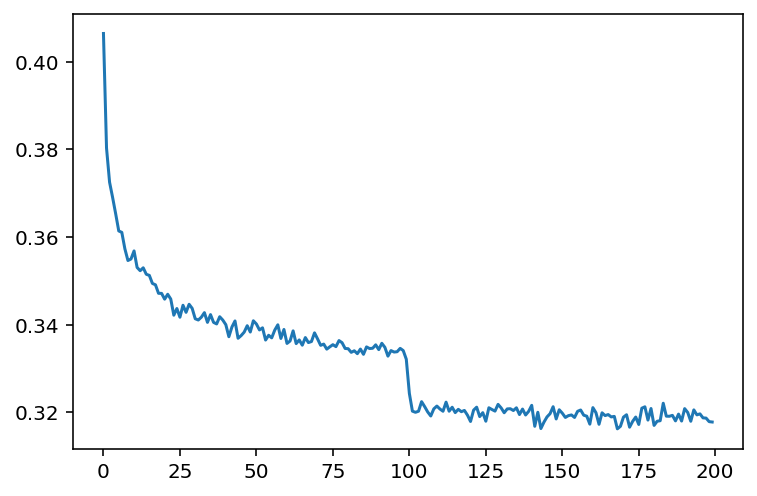

In [45]:
plt.plot(torch.tensor(loss_history).view(-1, 1000).mean(1));

In [47]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [48]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]
    # forward pass
    logits = model(x)
    # calculate the loss
    loss = F.cross_entropy(logits, y)
    return loss.item()

print('Train loss:', split_loss('train'))

Train loss: 2.061648368835449


In [41]:
# generate a name
def generate_name():
    # sample a context
    context = [0] * block_size
    # generate a name
    name = []
    while True:
        # convert to a tensor
        logits = model(torch.tensor(context).unsqueeze(0))
        # sample a character
        p = F.softmax(logits, dim=-1)
        char_idx = torch.multinomial(p, 1).item()
        # stop if we sampled the padding character
        if char_idx == 0:
            break
        # update the context
        context = context[1:] + [char_idx]
        # add the character to the name
        name.append(int2char[char_idx])
    return ''.join(name)

In [51]:
# set seed
for _ in range(10):
    print(generate_name())

demunt
madivyani
dais
mondalis
fredriana
hayanai
millynn
geor
sil
micultonie


## WaveNet: A Generative Model for Raw Audio

In [52]:
# change block size to 8
block_size = 8

def build_dataset(words):
    X, Y = [], []
    for word in words:
        # add . as the padding character to the beginning of the word
        context = [0] * block_size
        for char in word + '.':
            X.append(context)
            Y.append(char2int[char])
            # update the context
            context = context[1:] + [char2int[char]]
    # convert to tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print('X:', X.shape, 'Y:', Y.shape)
    return X, Y

In [53]:
# build the datasets
# split the dataset into training and validation sets
# 80%, 10%, 10%
# set the random seed
random.seed(666)
# shuffle the words
random.shuffle(words)
# split the words
train_words = words[:int(0.8*len(words))]
val_words = words[int(0.8*len(words)):int(0.9*len(words))]
test_words = words[int(0.9*len(words)):]

# build the datasets
X_train, Y_train = build_dataset(train_words)
X_val, Y_val = build_dataset(val_words)
X_test, Y_test = build_dataset(test_words)

X: torch.Size([182482, 8]) Y: torch.Size([182482])
X: torch.Size([22831, 8]) Y: torch.Size([22831])
X: torch.Size([22833, 8]) Y: torch.Size([22833])


In [58]:
# take a look at the data
for x, y in zip(X_train[:20], Y_train[:20]):
    print(''.join(int2char[i.item()] for i in x), "--->", int2char[y.item()])

........ ---> k
.......k ---> y
......ky ---> m
.....kym ---> b
....kymb ---> e
...kymbe ---> r
..kymber ---> l
.kymberl ---> y
kymberly ---> n
ymberlyn ---> n
mberlynn ---> .
........ ---> j
.......j ---> o
......jo ---> b
.....job ---> y
....joby ---> .
........ ---> a
.......a ---> l
......al ---> e
.....ale ---> y


In [88]:
# train the model
n_embed = 10
n_hidden = 200 
# layers = [
#     Embedding(vocab_size, n_embed),
#     Flatten(),
#     Linear(n_embed*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden,vocab_size)
# ]

model = Sequential([
    Embedding(vocab_size, n_embed),
    Flatten(),
    Linear(n_embed*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size)
])

with torch.no_grad():
    # last layer is less confident, which means the weight is smaller
    model.layers[-1].weight *= 0.1


# collect all the parameters
params = model.parameters()
# print the number of parameters
print('Number of parameters:', sum(p.numel() for p in params))
# set gradient 
for p in params:
    p.requires_grad = True

Number of parameters: 22097


In [64]:
# go through the tensor morph
# morph means change the shape of the tensor
sample_idx = torch.randint(0, len(X_train), (5,))
sample_X = X_train[sample_idx]
print('Sample X:', sample_X.shape)
sample_X

Sample X: torch.Size([5, 8])


tensor([[ 0,  0,  0,  0,  0, 12, 25, 14],
        [ 0,  0,  0,  0,  0, 13,  1,  8],
        [ 0,  0,  0,  0,  0,  0,  3,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  5],
        [12, 12,  9, 26,  1,  2,  5, 20]])

In [67]:
# goes through the embedding layer
sample_X_embed = model.layers[0](sample_X)
print('Sample X embed:', sample_X_embed.shape)
# goes through the flatten layer
sample_X_flat = model.layers[1](sample_X_embed)
print('Sample X flat:', sample_X_flat.shape)
# goes through the linear layer
sample_X_lin = model.layers[2](sample_X_flat)
print('Sample X lin:', sample_X_lin.shape)

Sample X embed: torch.Size([5, 8, 10])
Sample X flat: torch.Size([5, 80])
Sample X lin: torch.Size([5, 200])


In [71]:
# we want to reshape the tensor
# from [5, 80] to [5, 4, 20]
# for instance
ex = torch.randn(5, 8, 10)
print('Example:', ex.shape)
ex.view(5, -1).shape
ex.view(5, 4, 20).shape

Example: torch.Size([5, 8, 10])


torch.Size([5, 4, 20])

In [72]:
class FlattenConsecutive:

    def __init__(self, n):
        # n is the number of consecutive dimensions to flatten
        self.n = n

    def __call__(self, x):
        # B means batch size, T means time steps, C means channels
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            # if the number of time steps is 1, squeeze the tensor
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        # this layer has no parameters
        return []

In [94]:
# block size is 8
# now let's build up our model
# train the model
n_embed = 10
n_hidden = 68
conv_size = 2
# layers = [
#     Embedding(vocab_size, n_embed),
#     Flatten(),
#     Linear(n_embed*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden,vocab_size)
# ]

model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(conv_size),
    Linear(n_embed*conv_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(conv_size),
    Linear(n_hidden*conv_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(conv_size),
    Linear(n_hidden*conv_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size)
])

with torch.no_grad():
    # last layer is less confident, which means the weight is smaller
    model.layers[-1].weight *= 0.1


# collect all the parameters
params = model.parameters()
# print the number of parameters
print('Number of parameters:', sum(p.numel() for p in params))
# set gradient 
for p in params:
    p.requires_grad = True

Number of parameters: 22397


In [75]:
# test with four observations
sample_idx = torch.randint(0, len(X_train), (4,))
sample_X, sample_Y = X_train[sample_idx], Y_train[sample_idx]
logits = model(sample_X)
print('sample x:', sample_X.shape)


sample x: torch.Size([4, 8])


In [77]:
for layer in model.layers:
    print(layer.__class__.__name__, 'output shape:\t', tuple(layer.out.shape))

Embedding output shape:	 (4, 8, 10)
FlattenConsecutive output shape:	 (4, 4, 20)
Linear output shape:	 (4, 4, 200)
BatchNorm1d output shape:	 (4, 4, 200)
Tanh output shape:	 (4, 4, 200)
FlattenConsecutive output shape:	 (4, 2, 400)
Linear output shape:	 (4, 2, 200)
BatchNorm1d output shape:	 (4, 2, 200)
Tanh output shape:	 (4, 2, 200)
FlattenConsecutive output shape:	 (4, 400)
Linear output shape:	 (4, 200)
BatchNorm1d output shape:	 (4, 200)
Tanh output shape:	 (4, 200)
Linear output shape:	 (4, 27)


In [95]:
# train the model
# train the model
max_steps = 200000 
batch_size = 32
loss_history = []

for i in range(max_steps):
    # get the batch
    batch_idx = torch.randint(0, len(X_train), (batch_size,))
    batch_X, batch_Y = X_train[batch_idx], Y_train[batch_idx]

    # forward pass
    logits = model(batch_X)
    # calculate the loss
    loss = F.cross_entropy(logits, batch_Y)

    # clear the previous gradients
    for p in params:
        p.grad = None
    loss.backward()

    # update the parameters
    alpha = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data -= alpha * p.grad

    # print the loss
    loss_history.append(loss.log10().item())
    
    if i % 10000 == 0:
        print(f'Step {i:7d}/{max_steps:7d}, loss {loss.item():.4f}')

Step       0/ 200000, loss 3.2912
Step   10000/ 200000, loss 2.2526
Step   20000/ 200000, loss 2.5611
Step   30000/ 200000, loss 2.4946


In [ ]:
# for layer in model.layers:
#     print(layer.__class__.__name__, 'output shape:\t', tuple(layer.out.shape))

In [92]:
model.layers[3].ema_mean.shape

torch.Size([1, 1, 68])

In [ ]:
# plot the loss
plt.plot(torch.tensor(loss_history).view(-1, 1000).mean(1))

In [81]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]
    # forward pass
    logits = model(x)
    # calculate the loss
    loss = F.cross_entropy(logits, y)
    return loss.item()

print('Train loss:', split_loss('train'))
print('Val loss:', split_loss('val'))
print('Test loss:', split_loss('test'))

Train loss: 1.9481027126312256
Val loss: 2.0203917026519775
Test loss: 2.0397560596466064
